In [1]:
import spacy

In [2]:
import spacy
# Cargar modelo ahora en ingles
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Descargando modelo...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# TEXTO DE ENTRADA
with open("Alchemised.txt", "r", encoding="utf-8") as f:
    texto_libro = f.read()

# Ahora 'texto_libro' contiene todo el texto del archivo
print(f"Texto cargado con éxito. Longitud: {len(texto_libro)} caracteres.")

# Aumentar el límite de longitud de SpaCy para textos largos
nlp.max_length = len(texto_libro) + 100  # Añadir un buffer por si acaso

# 1. TOKENIZACIÓN
# SpaCy procesa el texto y crea el objeto 'doc' lleno de metadatos
doc = nlp(texto_libro)

# Mostrar los primeros 15 tokens para entender cómo "ve" la máquina el texto
print(f"--- 1. Tokenización (Total tokens: {len(doc)}) ---")
print([token.text for token in doc][:20])

Texto cargado con éxito. Longitud: 1852048 caracteres.
--- 1. Tokenización (Total tokens: 412777) ---
['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n', 'About', 'the', 'Author', '\n\n', 'SenLinYu', 'grew', 'up', 'in', 'the', 'Pacific', 'Northwest', 'and', 'studied', 'classical', 'liberal', 'arts', 'and', 'culture', '.']


In [3]:
# 2. FILTRADO DE STOP WORDS
# Separamos lo que aporta valor semántico del "pegamento" gramatical

tokens_relevantes = []
tokens_ruido = []

for token in doc:
    # Filtramos si es stopword o si es puntuación
    if not token.is_stop and not token.is_punct and token.text.strip():
        tokens_relevantes.append(token.text)
    elif token.is_stop:
        tokens_ruido.append(token.text)

print(f"\n--- 2. Filtrado de Stop Words ---")
print(f"Palabras eliminadas (Ruido): {tokens_ruido[:10]}...")
print(f"Palabras conservadas (Contenido): {tokens_relevantes[:10]}...")
print(f"Reducción de tamaño: de {len(doc)} a {len(tokens_relevantes)} tokens.")


--- 2. Filtrado de Stop Words ---
Palabras eliminadas (Ruido): ['About', 'the', 'up', 'in', 'the', 'and', 'and', 'They', 'in', 'the']...
Palabras conservadas (Contenido): ['Author', 'SenLinYu', 'grew', 'Pacific', 'Northwest', 'studied', 'classical', 'liberal', 'arts', 'culture']...
Reducción de tamaño: de 412777 a 137527 tokens.


In [4]:
# 3. LEMATIZACIÓN Y NORMALIZACIÓN FINAL
# Reducimos las palabras a su raíz (Lema) y estandarizamos a minúsculas
# Objetivo: Que "hablo", "hablaré" y "habla" cuenten como el mismo concepto: "hablar"

tokens_normalizados = []
cambios_interesantes = []

for token in doc:
    # Aplicamos los mismos filtros de calidad que en el paso 2
    if not token.is_stop and not token.is_punct and token.text.strip():

        # AQUÍ OCURRE LA MAGIA:
        # 1. Extraemos el lema (token.lemma_)
        # 2. Convertimos a minúsculas (.lower())
        lema = token.lemma_.lower()
        tokens_normalizados.append(lema)

        # Para fines educativos: Guardamos casos donde la palabra cambió drásticamente
        # Ej: "fui" -> "ir"
        if token.text.lower() != lema:
            cambios_interesantes.append(f"{token.text} ➡ {lema}")

print(f"\n--- 3. Lematización y Normalización ---")
print(f"Total de tokens procesados: {len(tokens_normalizados)}")
print(f"Ejemplos de transformaciones (Palabra original ➡ Lema):")
# Mostramos solo los primeros 5 cambios para no saturar la pantalla
print(cambios_interesantes[:10])

print(f"\nResultado final (Primeros 10 tokens):")
print(tokens_normalizados[:10])


--- 3. Lematización y Normalización ---
Total de tokens procesados: 137527
Ejemplos de transformaciones (Palabra original ➡ Lema):
['grew ➡ grow', 'studied ➡ study', 'arts ➡ art', 'started ➡ start', 'writing ➡ write', 'collected ➡ collect', 'works ➡ work', 'garnered ➡ garner', 'downloads ➡ download', 'translated ➡ translate']

Resultado final (Primeros 10 tokens):
['author', 'senlinyu', 'grow', 'pacific', 'northwest', 'study', 'classical', 'liberal', 'art', 'culture']


In [5]:
import pandas as pd
from nltk.stem import SnowballStemmer

# Configuración del Stemmer (NLTK)
stemmer = SnowballStemmer("english")

# Comparativa lado a lado
data_comparativa = []

for token in doc:
    # Solo analizamos palabras, ignoramos puntuación y espacios para claridad
    if not token.is_punct and not token.is_space:

        # A. STEMMING (Corte de sufijos)
        raiz_stem = stemmer.stem(token.text)

        # B. LEMATIZACIÓN (Análisis morfológico de SpaCy)
        # Nota: SpaCy usa el contexto para saber si 'fui' es 'ir' o 'ser'
        lema = token.lemma_

        data_comparativa.append({
            "Original": token.text,
            "Stemming (Corte)": raiz_stem,
            "Lematización (Diccionario)": lema,
            "¿Coinciden?": raiz_stem == lema
        })

# Crear DataFrame para visualizar
df = pd.DataFrame(data_comparativa)


print(f"\n--- 3. Stemming vs Lematización ---")
# Mostramos palabras interesantes donde se vea la diferencia
# Buscamos verbos conjugados o plurales
palabras_interesantes = ["magic", "forgotten", "are", "secrets", "invisible", "power"]
filtro = df[df["Original"].isin(palabras_interesantes)]

print(filtro.to_string(index=False))


print("\n--- Visualización completa de los primeros 10 tokens ---")
print(df.head(10).to_string(index=False))


--- 3. Stemming vs Lematización ---
 Original Stemming (Corte) Lematización (Diccionario)  ¿Coinciden?
      are              are                         be        False
      are              are                         be        False
forgotten        forgotten                     forget        False
      are              are                         be        False
      are              are                         be        False
      are              are                         be        False
      are              are                         be        False
      are              are                         be        False
      are              are                         be        False
      are              are                         be        False
forgotten        forgotten                     forget        False
forgotten        forgotten                     forget        False
      are              are                         be        False
      are              ar

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
corpus_lematizado=[]
for oracion in doc.sents:
    lemas_oracion = [
        token.lemma_.lower() 
        for token in oracion 
        if not token.is_punct and not token.is_space and not token.is_stop
    ]
    if lemas_oracion:
        corpus_lematizado.append(" ".join(lemas_oracion))

print(f"Total de oraciones procesadas: {len(corpus_lematizado)}")

Total de oraciones procesadas: 27938


In [8]:
# Para Bag of Words
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(corpus_lematizado)

In [9]:
# Para TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(corpus_lematizado)

In [10]:
print(X_bow.shape)
print(X_tfidf.shape)

(27938, 9173)
(27938, 9173)


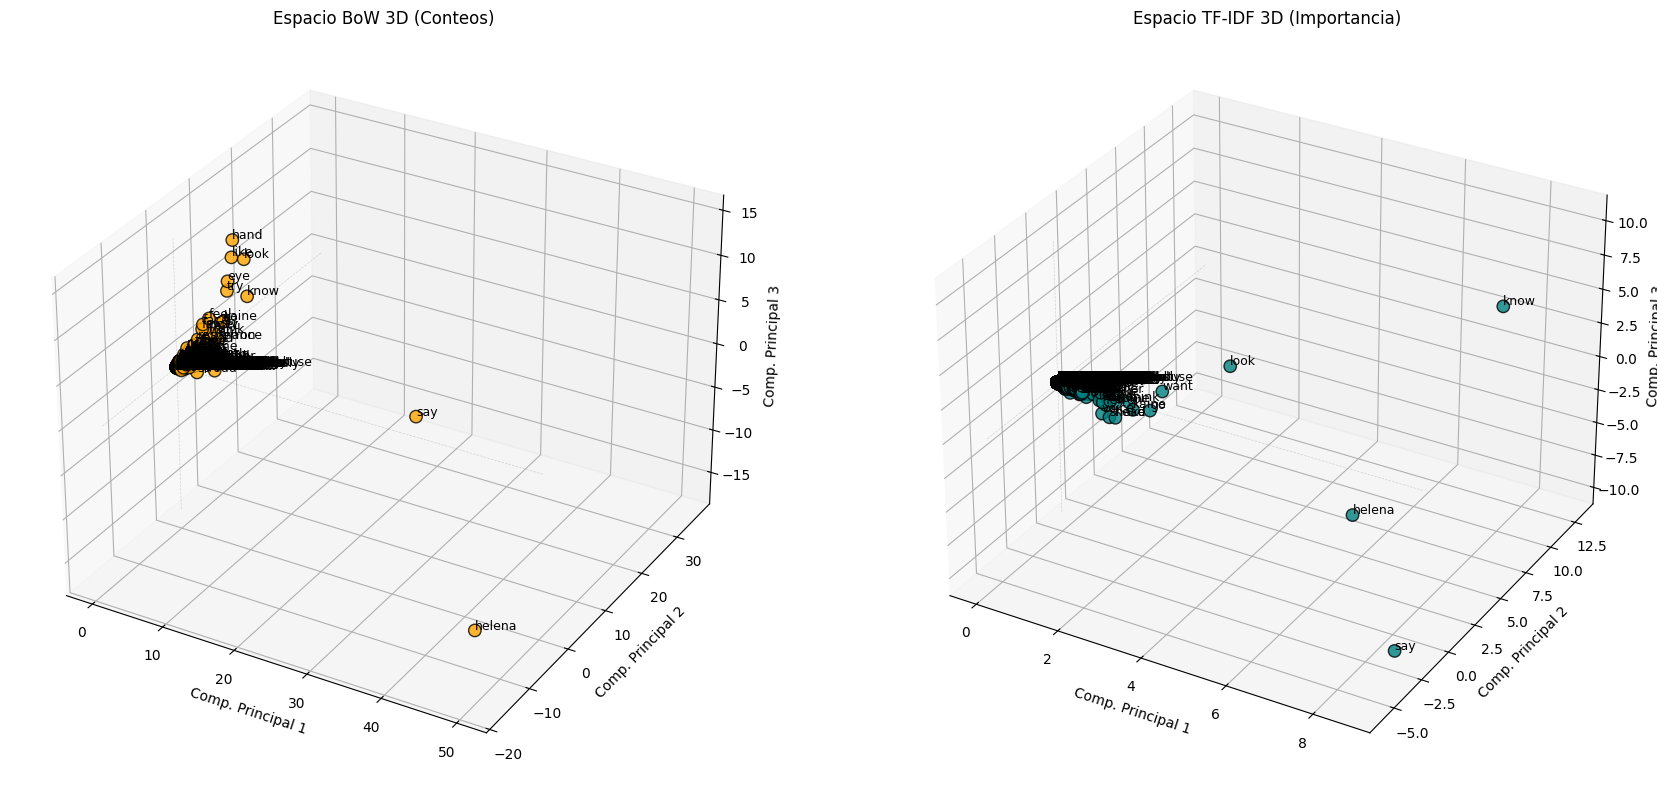

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import necesario para 3D
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np

# ---------------------------------------------------------
# FUNCIÓN AUXILIAR PARA GRAFICAR EN 3D
# ---------------------------------------------------------
def graficar_palabras_3d(ax, matriz, vocabulario, titulo, color_puntos):
    # 1. TRANSPONER: Filas = Palabras, Columnas = Contextos
    matriz_palabras = matriz.T
    
    # 2. PCA: Reducir a 3 DIMENSIONES
    pca = PCA(n_components=3)
    coords = pca.fit_transform(matriz_palabras.toarray())
    
    # Extraer coordenadas X, Y, Z
    x = coords[:, 0]
    y = coords[:, 1]
    z = coords[:, 2]
    
    # 3. GRAFICAR SCATTER 3D
    # Usamos profundidad visual (depthshade=True) para ayudar a la perspectiva
    ax.scatter(x, y, z, c=color_puntos, s=80, edgecolors='k', alpha=0.8, depthshade=True)
    
    # Etiquetar puntos
    for i, palabra in enumerate(vocabulario):
        # Agregamos un pequeño offset a Z para que el texto flote sobre el punto
        ax.text(x[i], y[i], z[i] + 0.1, palabra, fontsize=9)
        
    ax.set_title(titulo)
    ax.set_xlabel('Comp. Principal 1')
    ax.set_ylabel('Comp. Principal 2')
    ax.set_zlabel('Comp. Principal 3')
    
    # Líneas de referencia en el origen (0,0,0)
    ax.plot([0,0], [0,0], [z.min(), z.max()], c='grey', ls='--', lw=0.5, alpha=0.3)
    ax.plot([x.min(), x.max()], [0,0], [0,0], c='grey', ls='--', lw=0.5, alpha=0.3)
    ax.plot([0,0], [y.min(), y.max()], [0,0], c='grey', ls='--', lw=0.5, alpha=0.3)


# ---------------------------------------------------------
# CONFIGURACIÓN DE LA FIGURA 3D
# ---------------------------------------------------------
# Creamos una figura ancha para poner dos gráficos lado a lado
fig = plt.figure(figsize=(18, 8))

# --- A. BAG OF WORDS (Izquierda) ---
# subplot(filas, columnas, índice, proyección)
ax1 = fig.add_subplot(121, projection='3d')

bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(corpus_lematizado)
vocab_bow = bow_vectorizer.get_feature_names_out()

graficar_palabras_3d(ax1, X_bow, vocab_bow, 
                     "Espacio BoW 3D (Conteos)", 
                     "orange")

# --- B. TF-IDF (Derecha) ---
ax2 = fig.add_subplot(122, projection='3d')

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(corpus_lematizado)
vocab_tfidf = tfidf_vectorizer.get_feature_names_out()

graficar_palabras_3d(ax2, X_tfidf, vocab_tfidf, 
                     "Espacio TF-IDF 3D (Importancia)", 
                     "teal")

plt.tight_layout()
plt.show()